In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("spam.csv")
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [3]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [4]:
df_ham = df[df['Category']=='ham']
df_ham.shape


(4825, 2)

Downsampling to create a more balanced dataset.

In [5]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [6]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])

#drop the older index
df_balanced=df_balanced.reset_index()
df_balanced=df_balanced.drop(
    columns=["index"],
)

df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [7]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced = df_balanced.drop("Category",axis=1)
df_balanced.sample(5)

,Message,spam
1031,Call 09094100151 to use ur mins! Calls cast 10...,1
962,"SMS. ac JSco: Energy is high, but u may not kn...",1
805,FREE RINGTONE text FIRST to 87131 for a poly o...,1
254,"K, fyi I'm back in my parents' place in south ...",0
288,What is the plural of the noun research?,0


In [8]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ferry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ferry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Text Preprocessing

In [9]:
stemmer=PorterStemmer()
corpus=[]

for message in df_balanced["Message"]:          
    message=re.sub("[^a-zA-Z0-9]"," ",message)#replace non-alphanumeric with space        
    message=message.lower()#convert every words to its lowercase    
    message=message.split()#split the word into individual word list
    
    #perform stemming
    message=[stemmer.stem(words) for words in message if words not in set(stopwords.words("english"))]   
    message=" ".join(message) #join the word lists with the whitespace
    corpus.append(message)

In [10]:
from tensorflow.keras.preprocessing.text import one_hot

vocab_size=10000
oneHot_doc=[one_hot(words,n=vocab_size) for words in corpus]

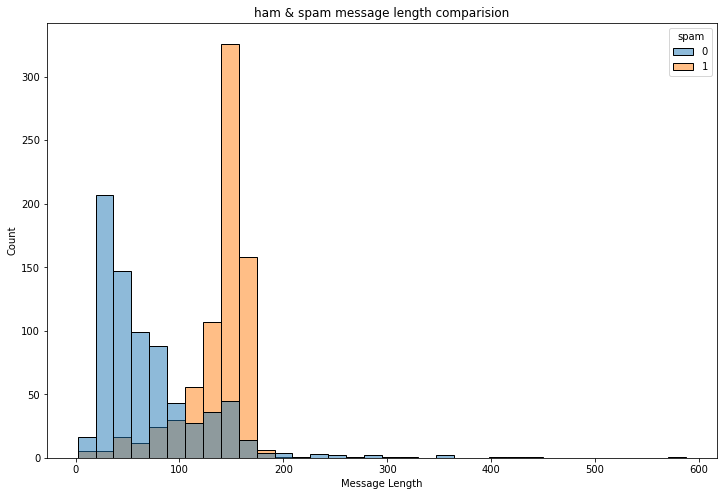

In [11]:
df_balanced["Message Length"]=df_balanced["Message"].apply(len)

fig=plt.figure(figsize=(12,8))
sns.histplot(x=df_balanced["Message Length"],hue=df_balanced["spam"])
plt.title("ham & spam message length comparision")
plt.show()

We will choose 200 lengths because of the plot range. We can see all messages concentrated from 0 to 200.

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

In [13]:
extract_features=pd.DataFrame(data=embedded_doc)
target=df_balanced["spam"]

df_final=pd.concat([extract_features,df_balanced['spam']],axis=1)
df_final.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,spam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9723,9602,7085,0
1,0,0,0,0,0,0,0,0,0,0,...,5200,448,448,8175,5837,136,5761,4311,235,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6052,5429,1153,0
3,0,0,0,0,0,0,0,0,0,0,...,6555,4506,7626,3555,5620,8702,6555,4506,7626,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5997,117,4743,0


In [17]:
X=df_final.drop("spam",axis=1)
y=df_final["spam"]

from sklearn.model_selection import train_test_split

X_trainval,X_test,y_trainval,y_test=train_test_split(X, y, random_state=42, test_size=0.15)

X_train,X_val,y_train,y_val=train_test_split(X_trainval, y_trainval, random_state=42, test_size=0.15)

Create and fit the LSTM network

In [22]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

feature_num=100
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=feature_num, input_length=sentence_len))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation="sigmoid"))
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)


Epoch 1/10
34/34 [==============================] - 21s 462ms/step - loss: 0.5409 - accuracy: 0.7161 - val_loss: 0.4844 - val_accuracy: 0.7539
Epoch 2/10
34/34 [==============================] - 14s 416ms/step - loss: 0.3116 - accuracy: 0.9276 - val_loss: 0.1749 - val_accuracy: 0.9476
Epoch 3/10
34/34 [==============================] - 13s 383ms/step - loss: 0.1007 - accuracy: 0.9703 - val_loss: 0.1224 - val_accuracy: 0.9529
Epoch 4/10
34/34 [==============================] - 14s 414ms/step - loss: 0.0523 - accuracy: 0.9889 - val_loss: 0.1072 - val_accuracy: 0.9634
Epoch 5/10
34/34 [==============================] - 14s 421ms/step - loss: 0.0318 - accuracy: 0.9935 - val_loss: 0.1171 - val_accuracy: 0.9476
Epoch 6/10
34/34 [==============================] - 15s 431ms/step - loss: 0.0229 - accuracy: 0.9954 - val_loss: 0.1141 - val_accuracy: 0.9634
Epoch 7/10
34/34 [==============================] - 14s 425ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.1280 - val_accuracy: 0.9476

In [23]:
from sklearn.metrics import accuracy_score,confusion_matrix

score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:96.44%


Text(0.5, 1.0, 'Confusion Matrix')

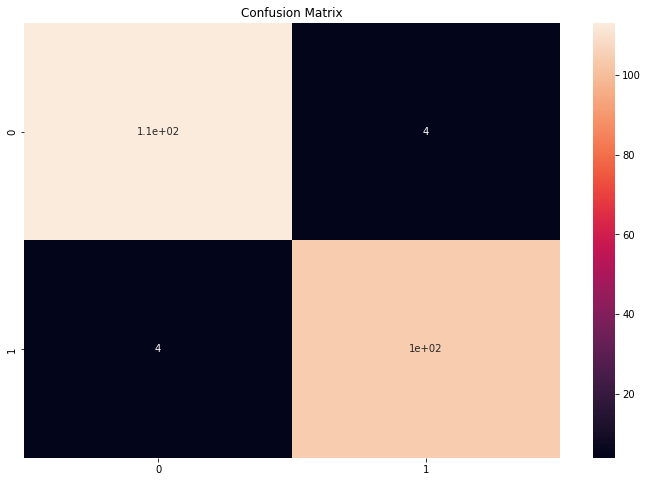

In [24]:
cm=confusion_matrix(y_test,y_pred)

fig=plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")


In [39]:
def spam_detection (model,message):
    for sentences in message:
        sentences=nltk.sent_tokenize(message)
        for sentence in sentences:
            words=re.sub("[^a-zA-Z0-9]"," ",sentence)
            if words not in set(stopwords.words('english')):
                word=nltk.word_tokenize(words)
                word=" ".join(word)         
    oneHot=[one_hot(word,n=vocab_size)]  
    text=pad_sequences(oneHot,maxlen=sentence_len,padding="pre")
    predict=model.predict(text)
    
    if predict>0.5:
        print("It is a spam")
    else:
        print("It is not a spam")

In [40]:
message1 = "Hi Zoro, do you want to listen to business seminar."
spam_detection(model,message1)

1/1 [==============================] - 0s 62ms/step
It is not a spam


In [41]:
message2 = "This is to inform you had won a lottery and the subscription will end in a week so call us."
spam_detection(model,message2)

1/1 [==============================] - 0s 63ms/step
It is a spam


In [42]:
message3 = "Wow! I can't believe crypto mining is real i just invested $100 and got back $10000 in just 2 hours."
spam_detection(model,message3)

1/1 [==============================] - 0s 63ms/step
It is a spam
